#####Features 

1.Age
2.No of timestamps
3.No of days spent in ICU 
4.Min value of time series variable
5.Max
Max - Min
6.Median
7.First value
8.Last value
9.No of value present for that variable
10.Whether a time series variable was measured or not ( binary feature)
11.If all values are NA (either for vitals or labs ) (binary)
12.Frequency of timestamp observations ( How frequent the timestamps were taken - frequent for serious cases )
13. SAPS and APACHE scores ( mortality models already in practice - to predict mortality )


#####Importing Libraries

In [2]:
# Importing Libraries 

import csv
import pandas as pd
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight')
from sklearn.covariance import EllipticEnvelope
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import scipy

In [2]:
print plt.style.available

[u'dark_background', u'bmh', u'grayscale', u'ggplot', u'fivethirtyeight']


In [2]:
# reading training files 

age=pd.read_csv('id_age_train.csv')
lbl=pd.read_csv('label_train.csv', index_col='ID')
vit=pd.read_csv('id_time_vitals_train.csv')
lab=pd.read_csv('id_time_labs_train.csv')

In [7]:
rolling_mean(vit)

NameError: name 'rolling_mean' is not defined

In [28]:
lab.info(memory_usage=True, dtype)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 628437 entries, 0 to 628436
Data columns (total 27 columns):
ID      628437 non-null int64
TIME    628437 non-null int64
L1      12471 non-null float64
L2      12790 non-null float64
L3      12831 non-null float64
L4      32719 non-null float64
L5      35741 non-null float64
L6      12961 non-null float64
L7      29993 non-null float64
L8      30131 non-null float64
L9      26986 non-null float64
L10     29835 non-null float64
L11     26593 non-null float64
L12     11119 non-null float64
L13     41 non-null float64
L14     1214 non-null float64
L15     1968 non-null float64
L16     4709 non-null float64
L17     104 non-null float64
L18     106199 non-null float64
L19     1484 non-null float64
L20     6330 non-null float64
L21     13184 non-null float64
L22     10879 non-null float64
L23     5775 non-null float64
L24     459 non-null float64
L25     16990 non-null float64
dtypes: float64(25), int64(2)
memory usage: 134.2 MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000AF555710>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000000C3E45EF0>]], dtype=object)

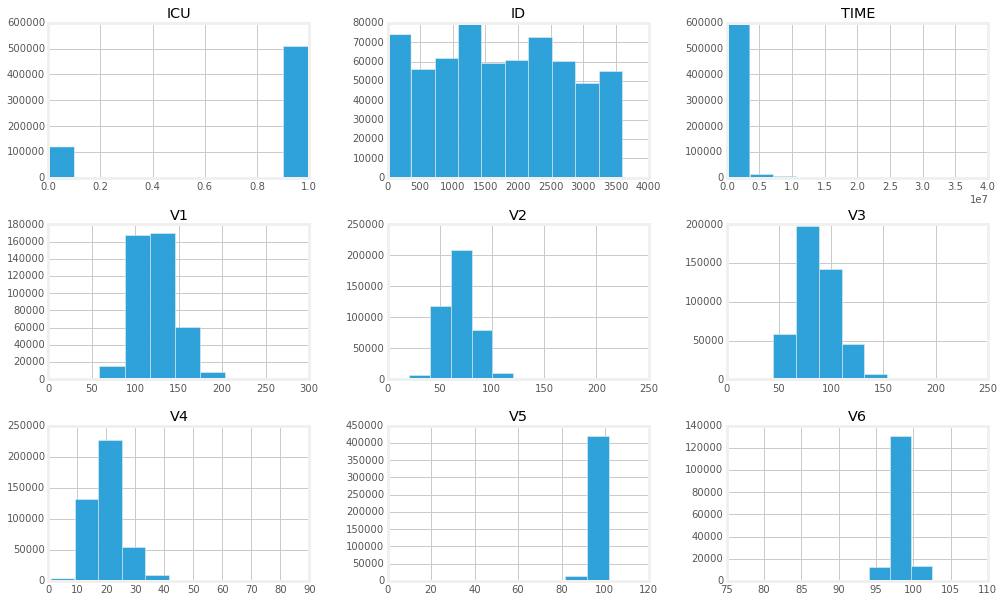

In [311]:
vit.hist(figsize=(15,10))

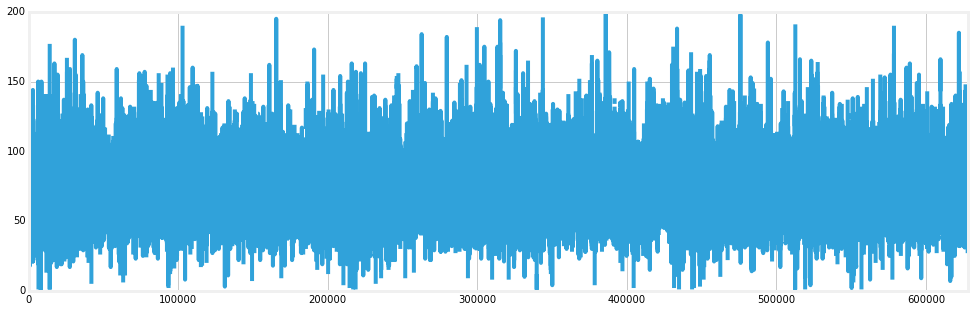

In [10]:
vit.V2.plot(figsize=(15,5))  # an exmple of time series variation

count    455161.000000
mean         86.815320
std          18.974359
min           1.000000
25%          73.000000
50%          85.000000
75%          98.000000
max         219.000000
Name: V3, dtype: float64

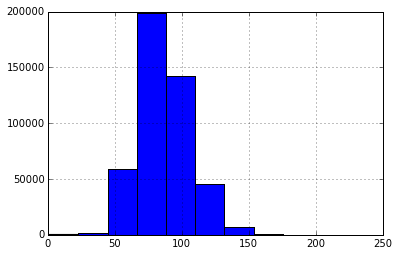

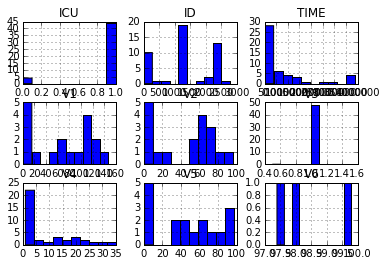

In [225]:
vit.V3.hist()   # Heart Rate -
vit[vit.V3==1].hist()
vit.V3.describe()

In [32]:
sum(pd.crosstab(vit.ID,vit.ICU)[0]==0) # total number of cases where ICU flag is always 1 for a patient

1124

In [19]:
lbl.LABEL.value_counts()

0    3349
1     245
dtype: int64

ICU
0      Axes(0.08,0.125;0.87x0.775)
1      Axes(0.08,0.125;0.87x0.775)
dtype: object

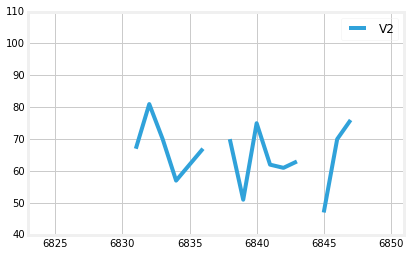

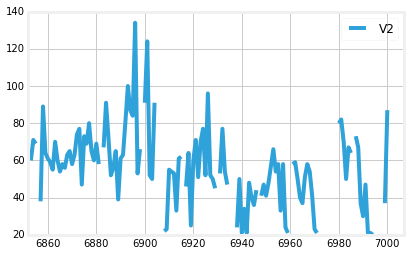

In [14]:
# plotting of time series variables - VITALS
vit[vit.ID==20][['V2','ICU']].groupby(by='ICU').plot()

In [28]:
# creating feature dataframe
feat=age 
feat['LABEL']=lbl.LABEL 

(<matplotlib.axes._subplots.AxesSubplot at 0x27b70ac8>,)

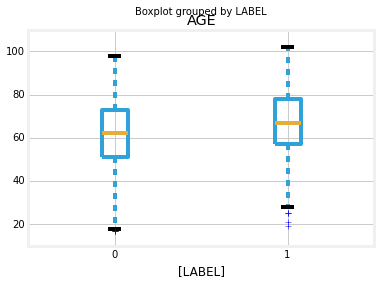

In [29]:
# boxplot for age vs labels
tmp=feat[['LABEL','AGE']]
tmp.boxplot(by='LABEL') , 

In [30]:
# adding number of measurements as feature to 'feat'

arr=[]
num_obs=len(vit.ID.value_counts())
counts=vit.ID.value_counts()
for i in range(num_obs):
#     print counts[i+1]
    arr.append(counts[i+1])
arr=np.array(arr)
feat['meas']=pd.Series(arr)  # added 'meas' column to feature table

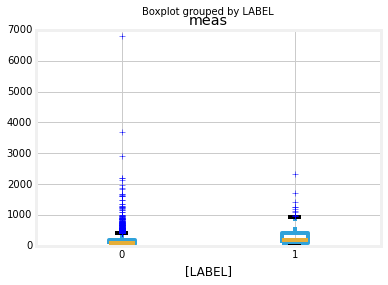

In [31]:

feat.groupby(by='LABEL').max()
# feat[feat.LABEL==1].meas.describe()
feat[['LABEL','meas']].boxplot( by='LABEL')

In [32]:
# cases where only labs are taken
sum(vit.V1.isnull() & vit.V2.isnull() &vit.V3.isnull()&vit.V4.isnull()&vit.V5.isnull()&vit.V6.isnull())

128003

In [33]:
feat=feat[feat.meas!=6787]  # removing outliers after seeing above graph 
feat=feat[feat.meas!=3697]
feat=feat[feat.meas!=2912]  
feat[['AGE','LABEL', 'meas']].groupby(by='LABEL').describe()

AGE         meas
LABEL                                
0     count  3346.000000  3346.000000
      mean     60.692767   161.884340
      std      16.229337   199.188148
      min      17.000000     1.000000
      25%      51.000000    54.000000
      50%      62.000000    99.000000
      75%      73.000000   193.000000
      max      98.000000  2190.000000
1     count   245.000000   245.000000
      mean     65.787755   299.493878
      std      15.695745   323.644077
      min      19.000000     1.000000
      25%      57.000000    80.000000
      50%      67.000000   184.000000
      75%      78.000000   425.000000
      max     102.000000  2340.000000

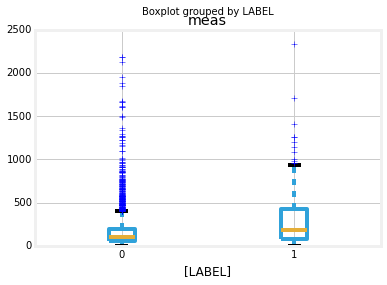

In [34]:
feat[['LABEL', 'meas']].boxplot(by='LABEL')

In [35]:
feat[['AGE', 'meas']].corr()   # Almost no relation between age and meas

,AGE,meas
AGE,1.000000,0.047177
meas,0.047177,1.000000


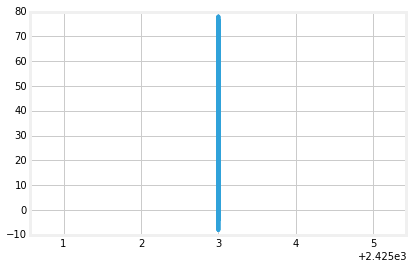

In [22]:
# plots of difference between timestamps
v=pd.read_csv('vitals_train.csv', index_col='ID')
v.loc[v.t_diff<0,'t_diff']=0
# v.t_diff[2428].hist()
# v[v.ID==2497].tail(30).t_diff.hist()
v['V2_mod']=v.V3-80
v.V2_mod[2428]

In [46]:
sum(vit.isnull()) # number of missing values in vitals

ID             0
TIME           0
V1        205300
V2        205399
V3        173276
V4        197946
V5        192806
V6        470494
ICU            0
t_diff         0
dtype: int64

In [29]:
print len(lab.L1),'\n', sum(lab.isnull())   # number of missing values in labs

628437 
ID           0
TIME         0
L1      615966
L2      615647
L3      615606
L4      595718
L5      592696
L6      615476
L7      598444
L8      598306
L9      601451
L10     598602
L11     601844
L12     617318
L13     628396
L14     627223
L15     626469
L16     623728
L17     628333
L18     522238
L19     626953
L20     622107
L21     615253
L22     617558
L23     622662
L24     627978
L25     611447
dtype: int64


In [94]:
vit[vit.V5>100]  # values of V5 > 100

,ID,TIME,V1,V2,V3,V4,V5,V6,ICU,t_diff
4,1,6342,139,90,107,29,101,NaN,1,639
5,1,6609,152,75,109,30,101,NaN,1,267
7,1,6957,140,72,108,31,101,NaN,1,63
14,1,12015,132,69,92,31,101,NaN,1,892
86,2,94029,103,71,109,17,101,NaN,1,629
88,2,95849,97,78,105,17,101,NaN,1,1662
89,2,97037,94,60,105,20,101,NaN,1,1188
91,2,100618,110,70,100,17,101,98.6,1,2329
463,5,391422,114,64,76,25,101,NaN,1,1470
795,5,749919,126,69,97,31,101,NaN,1,888


In [54]:
# Inserting labels into Vitals file as per ID's
arr=[]
l=len(vit)
for item in vit.iterrows():
    arr.append(lbl.LABEL[item[1].ID])

In [55]:
arr=np.array(arr)
arr=pd.Series(arr)
vit['Label']=arr

In [62]:
vit.fillna(np.nan)
vit.to_csv('vit&label.csv')

In [80]:
vit.describe()

,ID,TIME,V1,V2,V3,V4,V5,V6,ICU,t_diff,Label
count,628437.000000,628437.000000,423137.000000,423038.000000,455161.000000,430491.000000,435631.000000,157943.000000,628437.000000,628437.000000,628437.000000
mean,1727.806905,1022408.279161,122.710737,69.210043,86.815320,20.426097,97.666431,98.242680,0.810113,0.491739,0.116760
std,1029.031829,2756239.769567,23.069533,15.151000,18.974359,6.011689,3.722011,1.234502,0.392212,145639.964262,0.321134
min,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,79.900000,0.000000,-35236735.000000,0.000000
25%,880.000000,130786.000000,106.000000,59.000000,73.000000,17.000000,96.000000,97.600000,1.000000,888.000000,0.000000
50%,1700.000000,362109.000000,120.000000,68.000000,85.000000,20.000000,98.000000,98.200000,1.000000,1817.000000,0.000000
75%,2574.000000,840985.000000,137.000000,78.000000,98.000000,23.000000,100.000000,98.800000,1.000000,4373.000000,0.000000
max,3594.000000,35236735.000000,290.000000,200.000000,219.000000,82.000000,102.000000,108.200000,1.000000,25482614.000000,1.000000


(array([  31.,   16.,   11.,    4.,    7.,   12.,   36.,   72.,  141.,  329.]),
 array([  0.,   6.,  12.,  18.,  24.,  30.,  36.,  42.,  48.,  54.,  60.]),
 <a list of 10 Patch objects>)

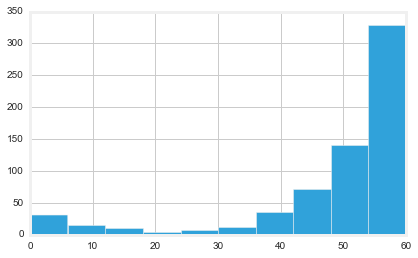

In [5]:
plt.hist(vit.V1, range=(0,60))

(array([  1.78010000e+04,   7.06400000e+03,   2.61600000e+03,
          7.67000000e+02,   2.33000000e+02,   1.05000000e+02,
          3.30000000e+01,   2.20000000e+01,   9.00000000e+00,
          3.00000000e+00]),
 array([ 160.,  173.,  186.,  199.,  212.,  225.,  238.,  251.,  264.,
         277.,  290.]),
 <a list of 10 Patch objects>)

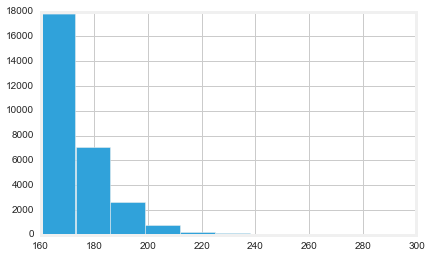

In [107]:
plt.hist(vit.V1, range=(160, vit.V1.max()))

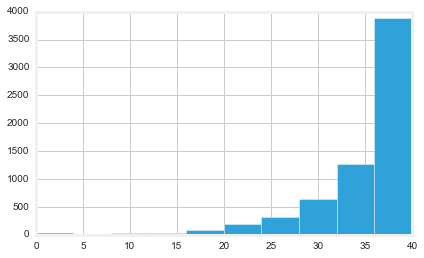

In [111]:
vit.V2.hist(range=(0,40))

11404

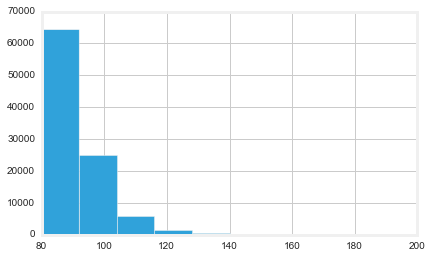

In [117]:
vit.V2.hist(range=(80, 200))
sum(vit.V2>100)

(array([  0.,   0.,  48.,   0.,   0.,  38.,   0.,  19.,   0.,   0.,   3.,
          0.,   3.,   0.,   0.,   1.,   0.,   3.,   0.,   0.,   1.,   0.,
          1.,   0.,   0.,   3.,   0.,   3.,   0.,   0.,   3.,   0.,   4.,
          0.,   0.,   7.,   0.,  10.,   0.,   0.,  20.,   0.,  27.,   0.,
          0.,  13.,   0.,  32.,   0.,   0.,  18.,   0.,  36.,   0.,   0.,
         30.,   0.,  20.,   0.,   0.,   9.,   0.,   5.,   0.,   0.,   9.,
          0.,  12.,   0.,   0.,   8.,   0.,  15.,   0.,   0.,  10.,   0.,
         18.,   0.,   0.,  25.,   0.,  32.,   0.,   0.,  29.,   0.,  44.,
          0.,   0.,  62.,   0.,  51.,   0.,   0.,  58.,   0.,  41.,   0.,
         45.]),
 array([  0. ,   0.4,   0.8,   1.2,   1.6,   2. ,   2.4,   2.8,   3.2,
          3.6,   4. ,   4.4,   4.8,   5.2,   5.6,   6. ,   6.4,   6.8,
          7.2,   7.6,   8. ,   8.4,   8.8,   9.2,   9.6,  10. ,  10.4,
         10.8,  11.2,  11.6,  12. ,  12.4,  12.8,  13.2,  13.6,  14. ,
         14.4,  14.8,  15.2,  15.6

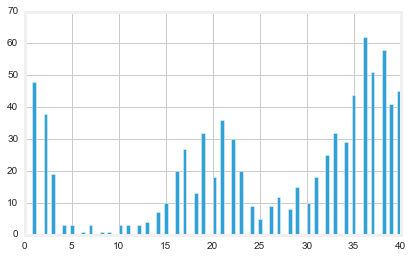

In [180]:
# vit.V3.hist(range=(0,40))
sum(vit.V3<30)
plt.hist(vit.V3, range=(0,40), bins=100)

609

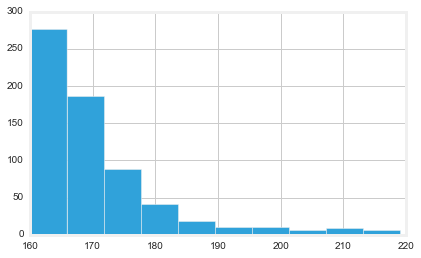

In [127]:

vit.V3.hist(range=(160,219))
sum(vit.V3>160)

8951

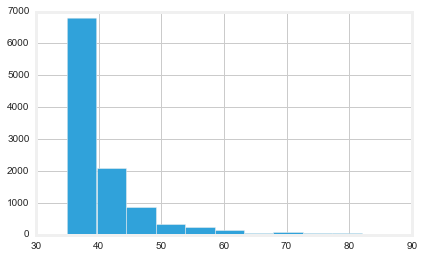

In [14]:
vit.V4.hist(range=(35,82))
sum(vit.V4>35)
# vit.V4.max()

39.0

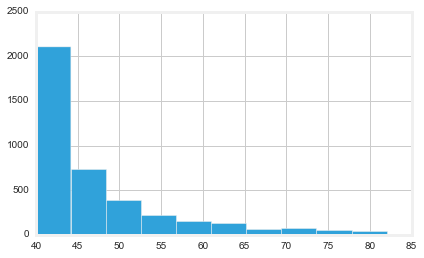

In [149]:
vit.V4.hist(range=(40,82))
vit.V4.quantile(0.99)

In [1]:
vit.V5.hist(range=(30,80))
sum(vit.V5>100)

NameError: name 'vit' is not defined

In [2]:
vit.V5.hist(range=(100,150))
sum(vit.V5>100)

NameError: name 'vit' is not defined

In [21]:
# vit.V6.hist(range=(vit.V6.min(),))
sum(vit.V6<85)
# vit.V6.max()

3